In [1]:
pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 24.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, Trainer, TrainingArguments, DataCollatorWithPadding
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import time

In [ ]:
# Load model and tokenizer
MODEL_NAME = "ura-hcmut/ura-llama-7b-r64"
#ACCESS_TOKEN = 

#quantization_config = BitsAndBytesConfig(load_in_8bit=False,load_in_4bit=True)
quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        load_in_8bit=False,
        llm_int8_threshold=6.0,
        llm_int8_has_fp16_weight=False,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
    )
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,trust_remote_code=True,token=access_token,model_max_length=2048,
        padding_side="left",
        truncation_side="left")
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME,
                                             token=access_token,
                                             device_map='auto',
                                             quantization_config=quantization_config)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/183 [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [4]:
# Prompting để dự đoán nhãn (Support, Refuted, Not Enough Info)
def generate_prompt(statement, context, evidence_list):
    evidence_text = "\n".join(evidence_list) if evidence_list else "No evidence provided."
    
    return f"""
        Kiểm tra tính chính xác của các tuyên bố dựa trên thông tin được cung cấp. 
        Đọc kỹ tuyên bố, ngữ cảnh và các bằng chứng, sau đó phân loại tuyên bố vào một trong ba nhãn:
        - *Support*: Nếu tuyên bố được hỗ trợ bởi ngữ cảnh hoặc bằng chứng.
        - *Refuted*: Nếu tuyên bố bị bác bỏ bởi ngữ cảnh hoặc bằng chứng.
        - *N.E.I*: Nếu Không đủ thông tin để xác minh tính đúng/sai của tuyên bố.

        ### Nhiệm vụ:
        1. Đọc và hiểu rõ *tuyên bố*: "{statement}".
        2. Đọc *ngữ cảnh* sau: "{context}".
        3. Phân tích *các bằng chứng liên quan* sau đây:
        {evidence_text if evidence_text else "Không có bằng chứng được cung cấp."}
        4. Dựa trên thông tin trên, phân loại tuyên bố vào một trong ba nhãn (*Support*, *Refuted*, hoặc *N.E.I*).
        5. Trả lời chỉ với duy nhất một nhãn chính xác và không giải thích thêm.

        ### Example Responses:
        - <RESPONSE>: Support
        - <RESPONSE>: Refuted
        - <RESPONSE>: N.E.I
    """
    
def fact_check(statement, context, evidence_list, tokenizer, model):
    try:
        # Generate the prompt
        prompt = generate_prompt(statement, context, evidence_list)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512)
        
        # Generate output from the model
        outputs = model.generate(**inputs, max_new_tokens=8, do_sample=False)
        
        # Decode and clean the response
        response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        response_label = response.split("<RESPONSE>:")[-1].strip()  # Extract label after <RESPONSE>:
        print(f"Kết quả: {response_label}\n")
        
        # Map the response label to numeric categories
        if "Support" in response_label:
            return 0
        elif "Refuted" in response_label:
            return 1
        elif "N.E.I" in response_label:
            return 2
        else:
            return -1  # Unexpected output
    
    except Exception as e:
        print(f"Error during fact-checking: {e}")
        return -1  # Fallback for errors

In [5]:
# Load data
train = pd.read_csv('/kaggle/input/vifactcheck/train_data.csv')
dev = pd.read_csv('/kaggle/input/vifactcheck/dev_data.csv')
test = pd.read_csv('/kaggle/input/vifactcheck/test_data.csv')

In [6]:
results = {}
predicted_labels = []
for index, row in test.iterrows():
    statement = row["Statement"]
    context = row["Context"]
    evidence_list = eval(row["Evidence_List"]) 
    
    print(f"Đang kiểm tra tuyên bố {index} trong testset: {statement}")
    
    try:
        # Predict label
        label = fact_check(statement, context, evidence_list, tokenizer, model)
        predicted_labels.append(label)
        print(f"Predicted label: {label} (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)\n")
    except Exception as e:
        print(f"Error processing statement {index}: {e}")
        predicted_labels.append(-1)

# Thêm nhãn dự đoán vào DataFrame hiện tại
test["Predicted_Label"] = predicted_labels

# Lưu kết quả vào file CSV
output_file = f"fact_check_results_test.csv"
test.to_csv(output_file, index=False, encoding="utf-8-sig")
print(f"Kết quả đã được lưu vào file '{output_file}'.")

# Lưu vào results dictionary
results['Test'] = test

Đang kiểm tra tuyên bố 0 trong testset: Bộ xương bản sao được đưa đến Lodon bằng cách nghép thành con hoàn chỉnh rồi vận chuyển đến.


/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:2097: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling f

Kết quả: N.E.I

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 1 trong testset: Phần vỏ bánh được làm rất công phu, từ giai đoạn xay gạo đến cuốn bánh hết tổng 4 tiếng đồng hồ.
Kết quả: N.E.I

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 2 trong testset: Đối tượng cố gắng bỏ chạy sau khi lực lượng công an đón dừng xe để kiểm tra.
Kết quả: N.E.I
    
    **Support**:

Predicted label: 0 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 3 trong testset: Vì lượng mưa khổng lồ do cơn bão tạo ra đã dẫn đến nhiều vụ sạt lở và ngập lụt, miền nam Mozambique nhận lượng mưa cao hơn gấp đôi hàng năm, và dự kiến nếu bão cứ tiếp tục độ bổ thì lượng mưa tại đây sẽ cao nhất trong lịch sử từ trước đến giờ.
Kết quả: N.E.I

Predicted label: 2 (0: Support, 1: Refuted, 2: Not Enough Info, -1: error)

Đang kiểm tra tuyên bố 4 trong testset: Tại một địa điểm trên địa bàn hu

In [7]:
# Evaluate Results
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

def evaluate_results(results_df, class_labels=["support", "refute", "nei"]):
    y_true = results_df["labels"].tolist()
    y_pred = results_df["Predicted_Label"].tolist()
    num_classes = len(class_labels)
    
    # Binarize labels for multi-class ROC and PR-AUC
    y_true_bin = label_binarize(y_true, classes=range(num_classes))
    y_pred_bin = label_binarize(y_pred, classes=range(num_classes))

    # Metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # ROC-AUC and PR-AUC calculations
    fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall_curve, precision_curve)

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score (Micro): {f1_micro:.2f}")
    print(f"F1 Score (Macro): {f1_macro:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print(f"PR-AUC: {pr_auc:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # ROC Curve and AUC for each class
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    # Precision-Recall Curve and PR-AUC for each class
    plt.figure(figsize=(10, 8))
    for i, label in enumerate(class_labels):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{label} (PR-AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.34
Precision: 0.24
Recall: 0.34
F1 Score (Micro): 0.34
F1 Score (Macro): 0.22
ROC-AUC: 0.49
PR-AUC: 0.62
Confusion Matrix:
[[ 60   0 448]
 [ 56   0 412]
 [ 46   0 425]]


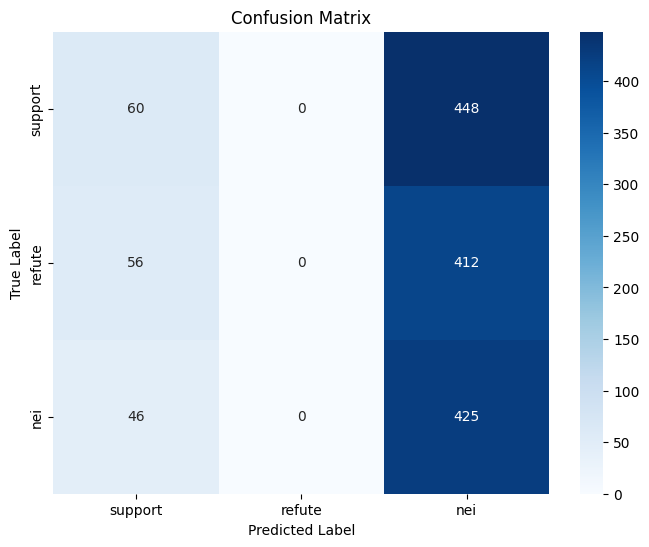

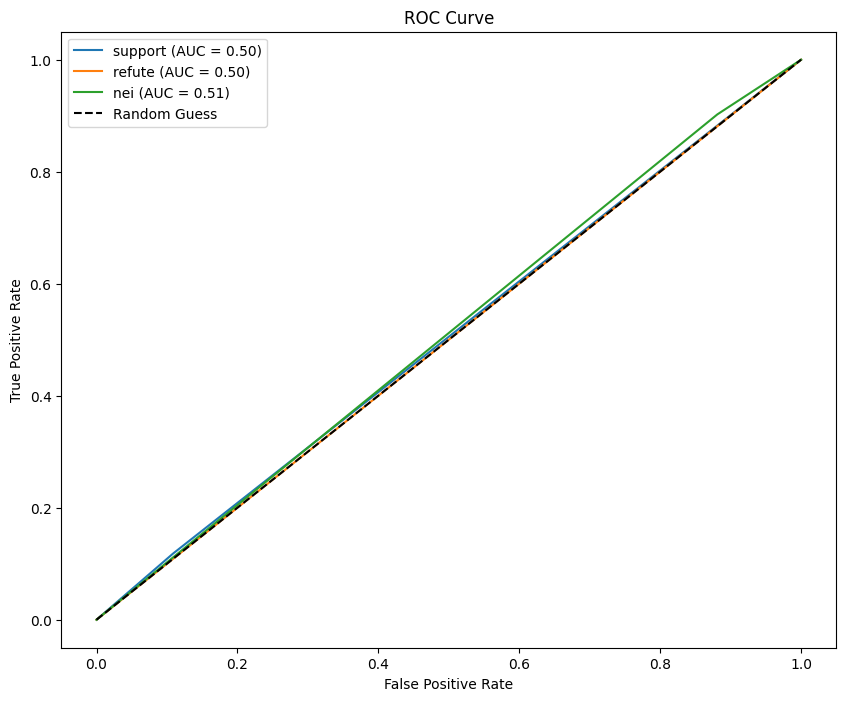

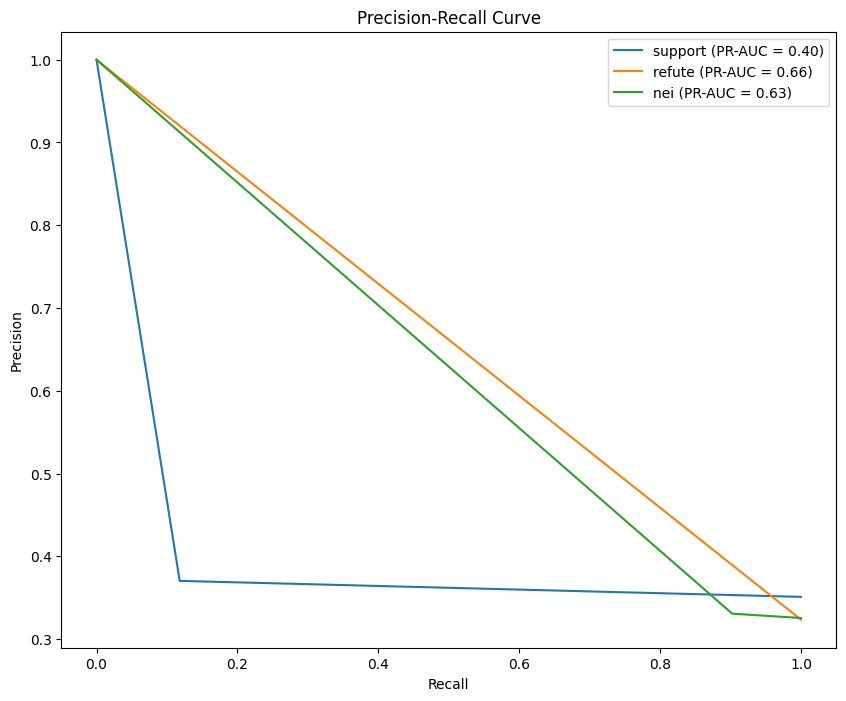

In [8]:
# Save and Evaluate
fact_check_results = pd.read_csv("fact_check_results_test.csv")
evaluate_results(fact_check_results)

In [9]:
'''
return f"""
        Classify the following statement into one of these categories based on the provided context and evidence:
        - **Support**: The statement is supported by the context or evidence.
        - **Refuted**: The statement is contradicted by the context or evidence.
        - **N.E.I**: There is insufficient information to verify the statement.

        ### Inputs:
        - Statement: "{statement}"
        - Context: "{context}"
        - Evidence: {evidence_text}

         ### Instructions:
        Respond with exactly one of the following labels: Support, Refuted, or Not Enough Info. 
        Do not include any additional text. The response must strictly follow this format:
        <RESPONSE>: [Label Here]
    
        ### Example Responses:
        - <RESPONSE>: Support
        - <RESPONSE>: Refuted
        - <RESPONSE>: N.E.I
    """
return f"""
        Kiểm tra tính chính xác của các tuyên bố dựa trên thông tin được cung cấp. 
        Đọc kỹ tuyên bố, ngữ cảnh và các bằng chứng, sau đó phân loại tuyên bố vào một trong ba nhãn:
        
        - *Support*: Tuyên bố được hỗ trợ bởi ngữ cảnh hoặc bằng chứng.
        - *Refuted*: Tuyên bố bị bác bỏ bởi ngữ cảnh hoặc bằng chứng.
        - *N.E.I*: Không đủ thông tin để xác minh tính đúng/sai của tuyên bố.

        ### Nhiệm vụ:
        1. Đọc và hiểu rõ *tuyên bố*: "{statement}".
        2. Đọc *ngữ cảnh* sau: "{context}".
        3. Phân tích *các bằng chứng liên quan* sau đây:
        {evidence_text if evidence_text else "Không có bằng chứng được cung cấp."}
        4. Dựa trên thông tin trên, phân loại tuyên bố vào một trong ba nhãn (*Support*, *Refuted*, hoặc *N.E.I*).
        5. Trả lời chỉ với nhãn chính xác (không giải thích thêm).

        ### Example Responses:
        - <RESPONSE>: Support
        - <RESPONSE>: Refuted
        - <RESPONSE>: N.E.I
    """
'''

'\nreturn f"""\n        Classify the following statement into one of these categories based on the provided context and evidence:\n        - **Support**: The statement is supported by the context or evidence.\n        - **Refuted**: The statement is contradicted by the context or evidence.\n        - **N.E.I**: There is insufficient information to verify the statement.\n\n        ### Inputs:\n        - Statement: "{statement}"\n        - Context: "{context}"\n        - Evidence: {evidence_text}\n\n         ### Instructions:\n        Respond with exactly one of the following labels: Support, Refuted, or Not Enough Info. \n        Do not include any additional text. The response must strictly follow this format:\n        <RESPONSE>: [Label Here]\n    \n        ### Example Responses:\n        - <RESPONSE>: Support\n        - <RESPONSE>: Refuted\n        - <RESPONSE>: N.E.I\n    """\nreturn f"""\n        Kiểm tra tính chính xác của các tuyên bố dựa trên thông tin được cung cấp. \n        Đ